# このノートブックでやること

- 実機データで学習する
- GRU + BuckConverterCell で学習する


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

np.random.seed(seed)

# 実機データの前処理


In [2]:
path0 = "../data/csv/tek0000ALL.csv"
path1 = "../data/csv/tek0001ALL.csv"


# 実機データのファイルのヘッダー確認
with open(path1, encoding="utf-8", errors="replace") as f:
    for i, line in enumerate(f, start=1):
        if i > 25:
            break
        print(f"{i:>5}: {line.rstrip()}")

    1: Model,MDO3024,
    2: Firmware Version,1.3,
    3: ,,
    4: Waveform Type,ANALOG,
    5: Point Format,Y,
    6: Horizontal Units,s,
    7: Horizontal Scale,0.0002,
    8: Horizontal Delay,0.000741,
    9: Sample Interval,2e-09,
   10: Record Length,1e+06,
   11: Gating,0.0% to 100.0%,
   12: Probe Attenuation,10,1
   13: Vertical Units,A,V
   14: Vertical Offset,0,0
   15: Vertical Scale,0.5,2
   16: Vertical Position,-2.82,0.04
   17: ,,
   18: ,,
   19: ,,
   20: Label,,
   21: TIME,CH1,CH2
   22: -2.59E-04,-0.09,-0.08
   23: -2.59E-04,-0.11,-0.08
   24: -2.59E-04,-0.11,-0.08
   25: -2.59E-04,-0.09,-0.08


In [3]:
df = pd.read_csv(path1, skiprows=20)

print(len(df))
df.head()

1000000


,TIME,CH1,CH2
0,-0.000259,-0.09,-0.08
1,-0.000259,-0.11,-0.08
2,-0.000259,-0.11,-0.08
3,-0.000259,-0.09,-0.08
4,-0.000259,-0.11,-0.16


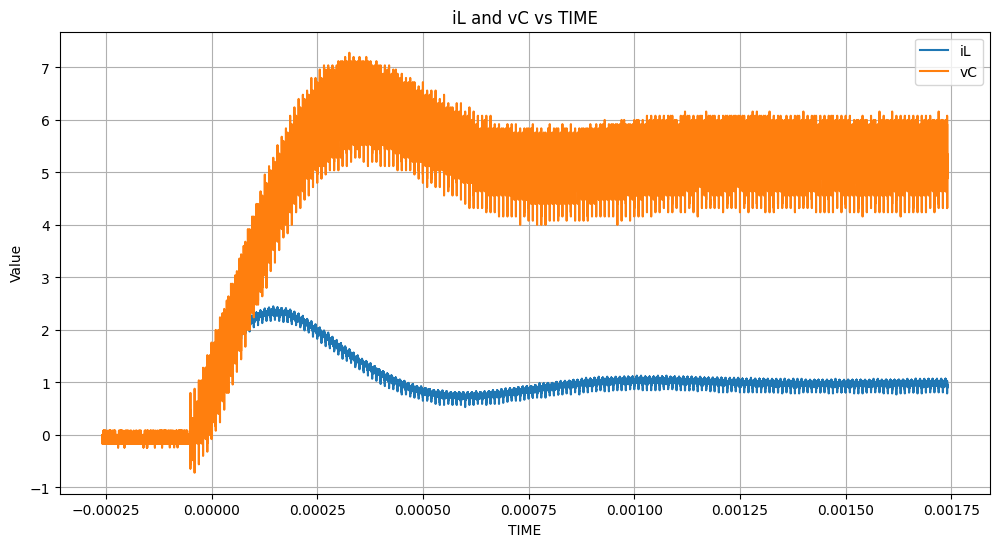

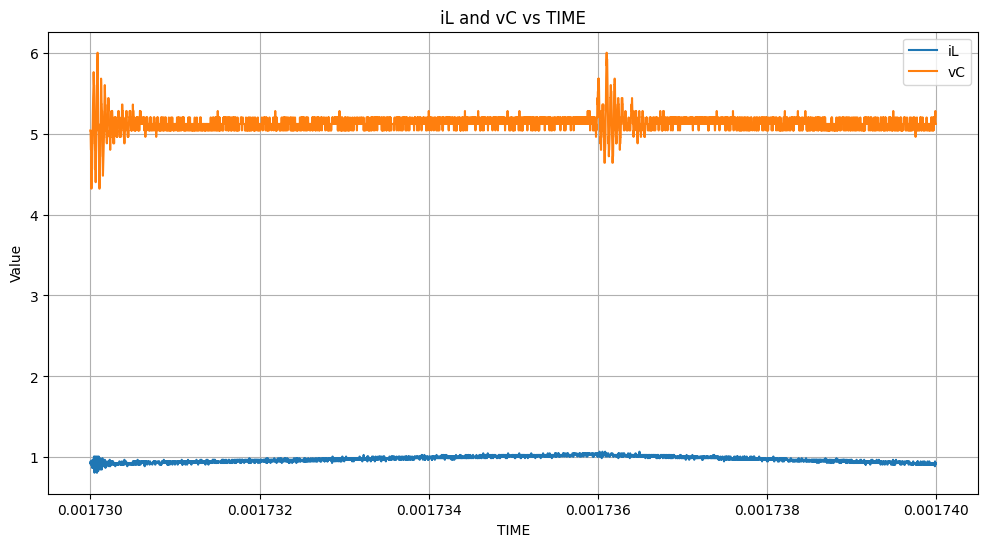

In [4]:
t_raw: np.ndarray = df["TIME"].to_numpy(dtype=np.float64)  # 秒
iL_raw: np.ndarray = df["CH1"].to_numpy(dtype=np.float32)  # A
vC_raw: np.ndarray = df["CH2"].to_numpy(dtype=np.float32)  # V


plt.figure(figsize=(12, 6))
plt.plot(t_raw, iL_raw, label="iL")
plt.plot(t_raw, vC_raw, label="vC")
plt.xlabel("TIME")
plt.ylabel("Value")
plt.title("iL and vC vs TIME")
plt.legend()
plt.grid(True)
plt.show()

# 1周期分の波形を表示
start_t, end_t = 0.00173, 0.00174
# start_t, end_t = -0.0001, 0.0001
mask: np.ndarray = (t_raw >= start_t) & (t_raw <= end_t)
_t = t_raw[mask]
_iL = iL_raw[mask]
_vC = vC_raw[mask]

plt.figure(figsize=(12, 6))
plt.plot(_t, _iL, label="iL")
plt.plot(_t, _vC, label="vC")
plt.xlabel("TIME")
plt.ylabel("Value")
plt.title("iL and vC vs TIME")
plt.legend()
plt.grid(True)
plt.show()

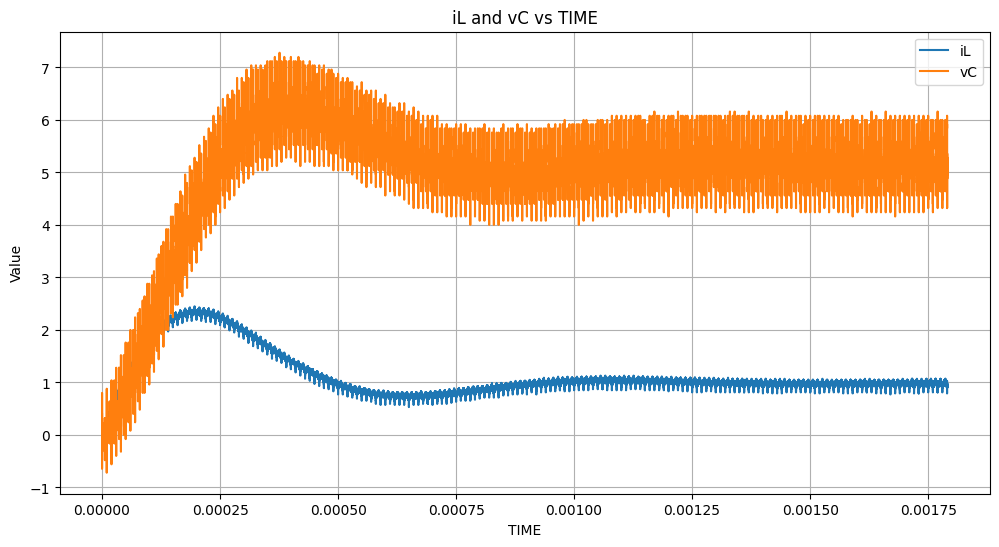

In [5]:
# Time 軸が -0.00005 から始まっているので、すべての時刻を +0.00005 し、0以上部分のみ抽出
t_all: np.ndarray = t_raw + 0.00005
mask: np.ndarray = t_all >= 0
t_all = t_all[mask]
iL_all = iL_raw[mask]
vC_all = vC_raw[mask]

plt.figure(figsize=(12, 6))
plt.plot(t_all, iL_all, label="iL")
plt.plot(t_all, vC_all, label="vC")
plt.xlabel("TIME")
plt.ylabel("Value")
plt.title("iL and vC vs TIME")
plt.legend()
plt.grid(True)
plt.show()


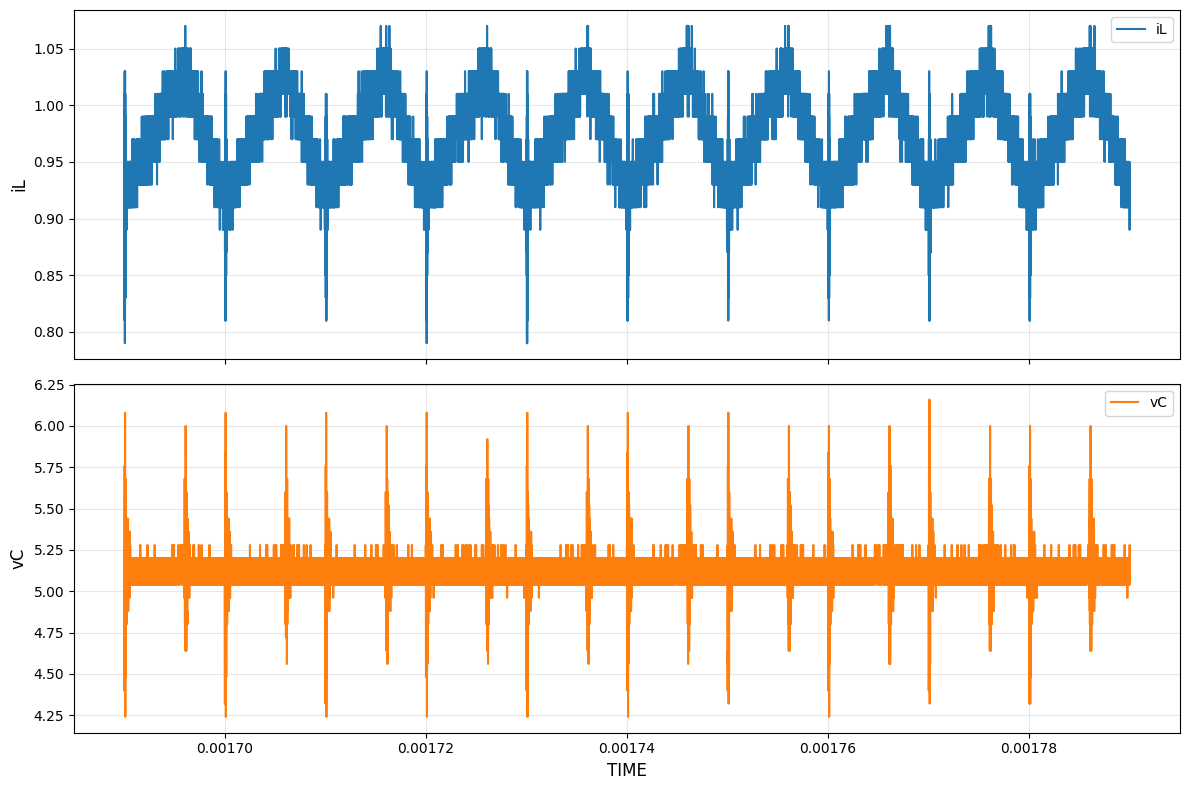

In [6]:
# 定常状態っぽいところを10周期分だけ切り出す
start_t, end_t = 0.00169, 0.00179
mask: np.ndarray = (start_t <= t_all) & (t_all <= end_t)
t = t_all[mask]
dt = t[1:] - t[:-1]
iL = iL_all[mask]
vC = vC_all[mask]


# iL と vC を別々のグラフに描画
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 上段: iL（上のセルの色に合わせる）
ax1.plot(t, iL, color="tab:blue", linewidth=1.5, label="iL")
ax1.set_ylabel("iL", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc="best")

# 下段: vC（上のセルの色に合わせる）
ax2.plot(t, vC, color="tab:orange", linewidth=1.5, label="vC")
ax2.set_ylabel("vC", fontsize=12)
ax2.set_xlabel("TIME", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc="best")

plt.tight_layout()
plt.show()

# 入力波形の再現


In [7]:
Vin = 10
Vref = 6
duty = Vref / Vin
f_sw = 1e5  # スイッチング周波数
T = 1 / f_sw  # 1周期の実時間

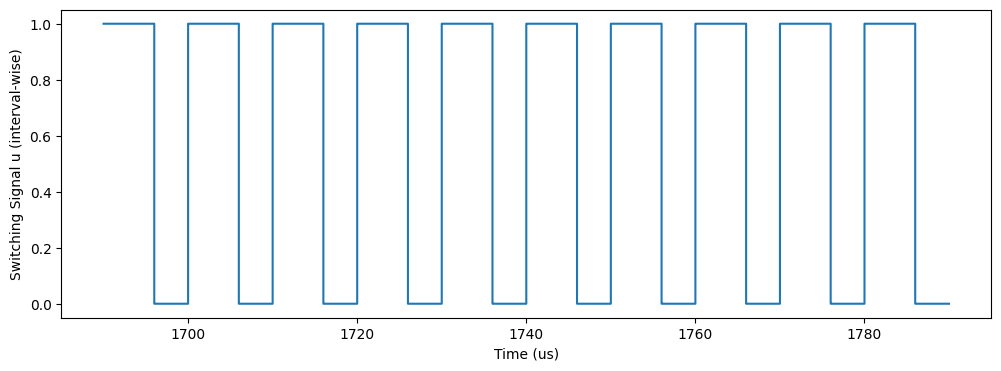

In [8]:
# スイッチング信号（不規則 dt 対応：時間基準でPWM生成）
duty_phase = (t[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t) - 1) * Vin

# プロット
plt.figure(figsize=(12, 4))
plt.step(t[:-1] * 1e6, u, where="post")
plt.xlabel("Time (us)")
plt.ylabel("Switching Signal u (interval-wise)")
plt.show()


# 学習データプロット


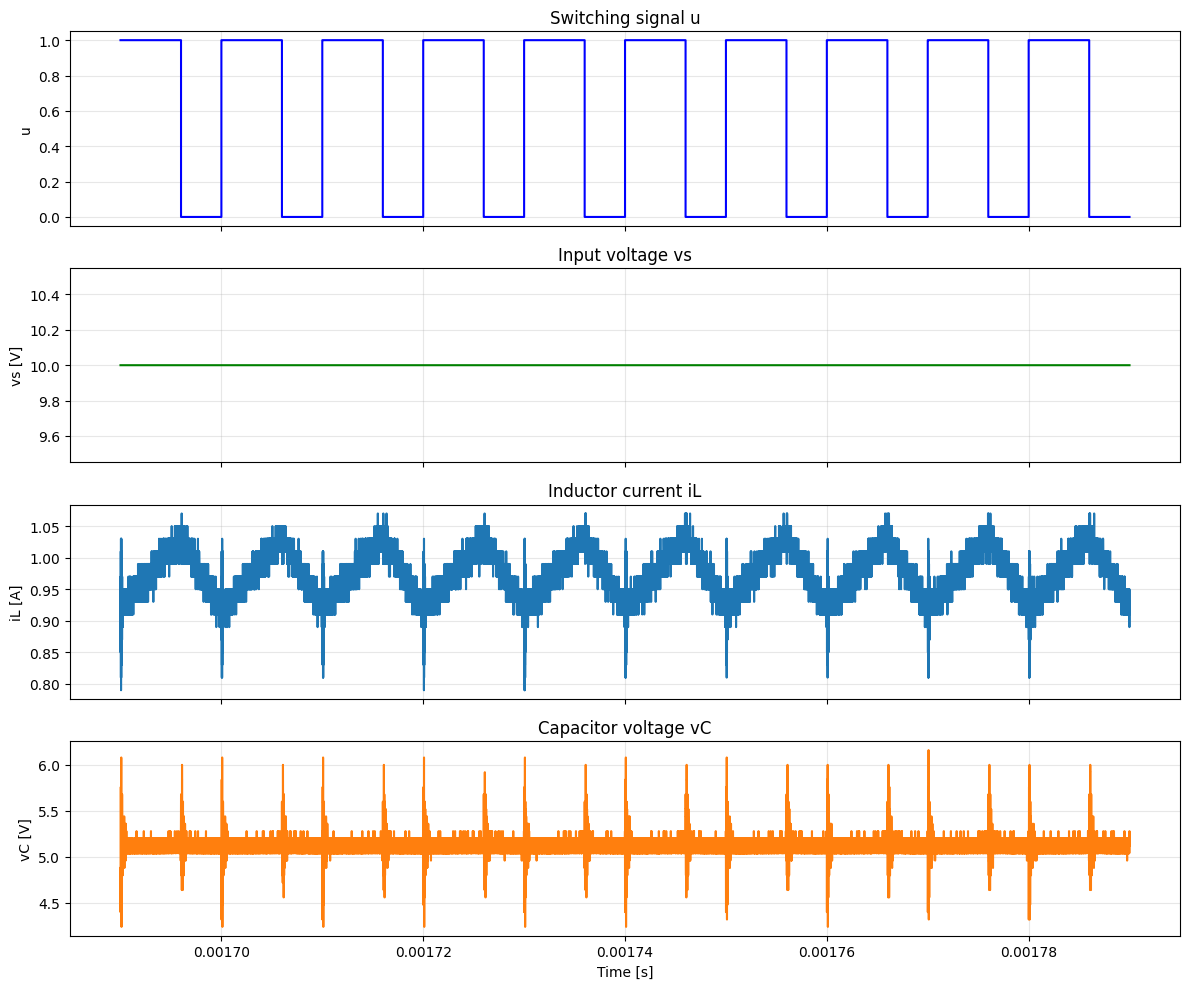

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# 1: u (switching signal)
axs[0].step(t[:-1], u, where="post", color="blue", linewidth=1.5)
axs[0].set_ylabel("u")
axs[0].grid(True, alpha=0.3)
axs[0].set_title("Switching signal u")

# 2: vs (input voltage)
axs[1].plot(t[:-1], vs, color="green", linewidth=1.5)
axs[1].set_ylabel("vs [V]")
axs[1].grid(True, alpha=0.3)
axs[1].set_title("Input voltage vs")

# 3: iL (inductor current)
axs[2].plot(t, iL, color="tab:blue", linewidth=1.5)
axs[2].set_ylabel("iL [A]")
axs[2].grid(True, alpha=0.3)
axs[2].set_title("Inductor current iL")

# 4: vC (capacitor voltage)
axs[3].plot(t, vC, color="tab:orange", linewidth=1.5)
axs[3].set_ylabel("vC [V]")
axs[3].set_xlabel("Time [s]")
axs[3].grid(True, alpha=0.3)
axs[3].set_title("Capacitor voltage vC")

plt.tight_layout()
plt.show()


# モデル定義


In [10]:
class BuckConverterCell(nn.Module):
    def __init__(
        self,
        L_init: float = 200e-6,
        C_init: float = 100e-6,
        R_init: float = 8.0,
    ) -> None:
        super().__init__()
        # パラメータを対数空間で学習（正の値を保証）
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(
        self,
        h: torch.Tensor,
        vs: torch.Tensor,
        u: torch.Tensor,
        dt: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        # h: [batch, 2] - [iL, vC]

        iL = h[:, 0]
        vC = h[:, 1]

        vs_tensor = torch.as_tensor(vs, dtype=iL.dtype, device=iL.device)
        u_tensor = torch.as_tensor(u, dtype=iL.dtype, device=iL.device)
        vp = vs_tensor * u_tensor
        dt_tensor = torch.as_tensor(dt, dtype=iL.dtype, device=iL.device)

        # パラメータを指数関数で変換（正の値を保証）
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        # DCM対応
        va = torch.where((vp == 0) & (iL <= 0), vC, vp)

        # オイラー法
        iL_next = iL + (dt_tensor / L) * (va - vC)
        iL_next = torch.relu(iL_next)  # 電流は負にならない（DCM考慮）

        vC_next = vC + (dt_tensor / C) * (iL - vC / R)

        return torch.stack([iL_next, vC_next], dim=1), va

    def get_params(self) -> dict:
        return {
            "L": torch.exp(self.log_L).item(),
            "C": torch.exp(self.log_C).item(),
            "R": torch.exp(self.log_R).item(),
            "log_L": self.log_L.item(),
            "log_C": self.log_C.item(),
            "log_R": self.log_R.item(),
        }

# 初期値


In [11]:
# # 固定パターン
L0 = 200e-6
C0 = 100e-6
R0 = 8.0

# # R 粗同定
# R0 = (vC.mean() / iL.mean()).item()
# print("R0 (coarse):", R0)


# # L 粗同定
# di = iL[1:] - iL[:-1]  # Δi_L
# x = dt * (vs * u - vC[:-1])  # Δt * (va - vC)

# L0 = np.sum(x * x) / np.sum(di * x)
# print("L0 (coarse):", L0)


# # C 粗同定
# dv = vC[1:] - vC[:-1]
# z = dt * (iL[:-1] - vC[:-1] / R0)

# C0 = np.sum(z * z) / np.sum(dv * z)
# print("C0 (coarse):", C0)


# 学習率


In [12]:
lr_L = 5e-2
lr_C = 1e-2
lr_R = 2e-2

# 学習


In [13]:
iL = torch.tensor(np.array(iL), dtype=torch.float32)
vC = torch.tensor(np.array(vC), dtype=torch.float32)

epochs = 1000

model = BuckConverterCell(L_init=L0, C_init=C0, R_init=R0)

optimizer = optim.Adam(
    [
        {"params": [model.log_L], "lr": lr_L},
        {"params": [model.log_C], "lr": lr_C},
        {"params": [model.log_R], "lr": lr_R},
    ]
)

loss_fn = nn.MSELoss()

loss_history = []
param_history = {"L": [], "C": [], "R": [], "log_L": [], "log_C": [], "log_R": []}

# 学習データの準備 - 次ステップ予測のためのペアを作成
h_seq = torch.stack([iL[:-1], vC[:-1]], dim=1)  # 現在の状態
h_target = torch.stack([iL[1:], vC[1:]], dim=1)  # 次時刻の状態


# 学習ループ
for epoch in range(epochs):
    optimizer.zero_grad()
    h_pred, _ = model(h_seq, vs, u, dt)
    loss = loss_fn(h_pred, h_target)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # パラメータの履歴を保存
    params = model.get_params()
    param_history["L"].append(params["L"])
    param_history["C"].append(params["C"])
    param_history["R"].append(params["R"])
    param_history["log_L"].append(params["log_L"])
    param_history["log_C"].append(params["log_C"])
    param_history["log_R"].append(params["log_R"])

    if epoch % 50 == 0:
        print(
            f"Epoch {epoch}: Loss={loss.item():.6e}  "
            f"L={params['L'] * 1e6:.1f}µH  "
            f"C={params['C'] * 1e6:.1f}µF  "
            f"R={params['R']:.2f}Ω"
        )
else:
    print("学習完了")
    print(
        f"Epoch {epoch}: Loss={loss.item():.6e}  "
        f"L={params['L'] * 1e6:.1f}µH  "
        f"C={params['C'] * 1e6:.1f}µF  "
        f"R={params['R']:.2f}Ω"
    )


Epoch 0: Loss=2.754980e-03  L=200.2µH  C=99.6µF  R=7.94Ω
Epoch 50: Loss=2.754977e-03  L=209.2µH  C=79.5µF  R=4.96Ω
Epoch 100: Loss=2.754948e-03  L=214.2µH  C=53.1µF  R=2.21Ω
Epoch 150: Loss=2.754831e-03  L=216.9µH  C=26.2µF  R=0.60Ω
Epoch 200: Loss=2.754820e-03  L=218.4µH  C=20.4µF  R=0.81Ω
Epoch 250: Loss=2.754793e-03  L=219.2µH  C=13.6µF  R=1.13Ω
Epoch 300: Loss=2.754735e-03  L=219.7µH  C=7.2µF  R=1.79Ω
Epoch 350: Loss=2.754502e-03  L=220.0µH  C=2.5µF  R=3.19Ω
Epoch 400: Loss=2.753192e-03  L=220.1µH  C=0.5µF  R=4.63Ω
Epoch 450: Loss=2.744949e-03  L=220.2µH  C=0.1µF  R=5.17Ω
Epoch 500: Loss=2.702308e-03  L=220.3µH  C=0.0µF  R=5.21Ω
Epoch 550: Loss=2.681566e-03  L=220.3µH  C=0.0µF  R=5.26Ω
Epoch 600: Loss=2.681557e-03  L=220.3µH  C=0.0µF  R=5.25Ω
Epoch 650: Loss=2.681555e-03  L=220.3µH  C=0.0µF  R=5.25Ω
Epoch 700: Loss=2.681555e-03  L=220.3µH  C=0.0µF  R=5.25Ω
Epoch 750: Loss=2.681555e-03  L=220.3µH  C=0.0µF  R=5.25Ω
Epoch 800: Loss=2.681556e-03  L=220.3µH  C=0.0µF  R=5.25Ω
Epoch 850: 

# 結果


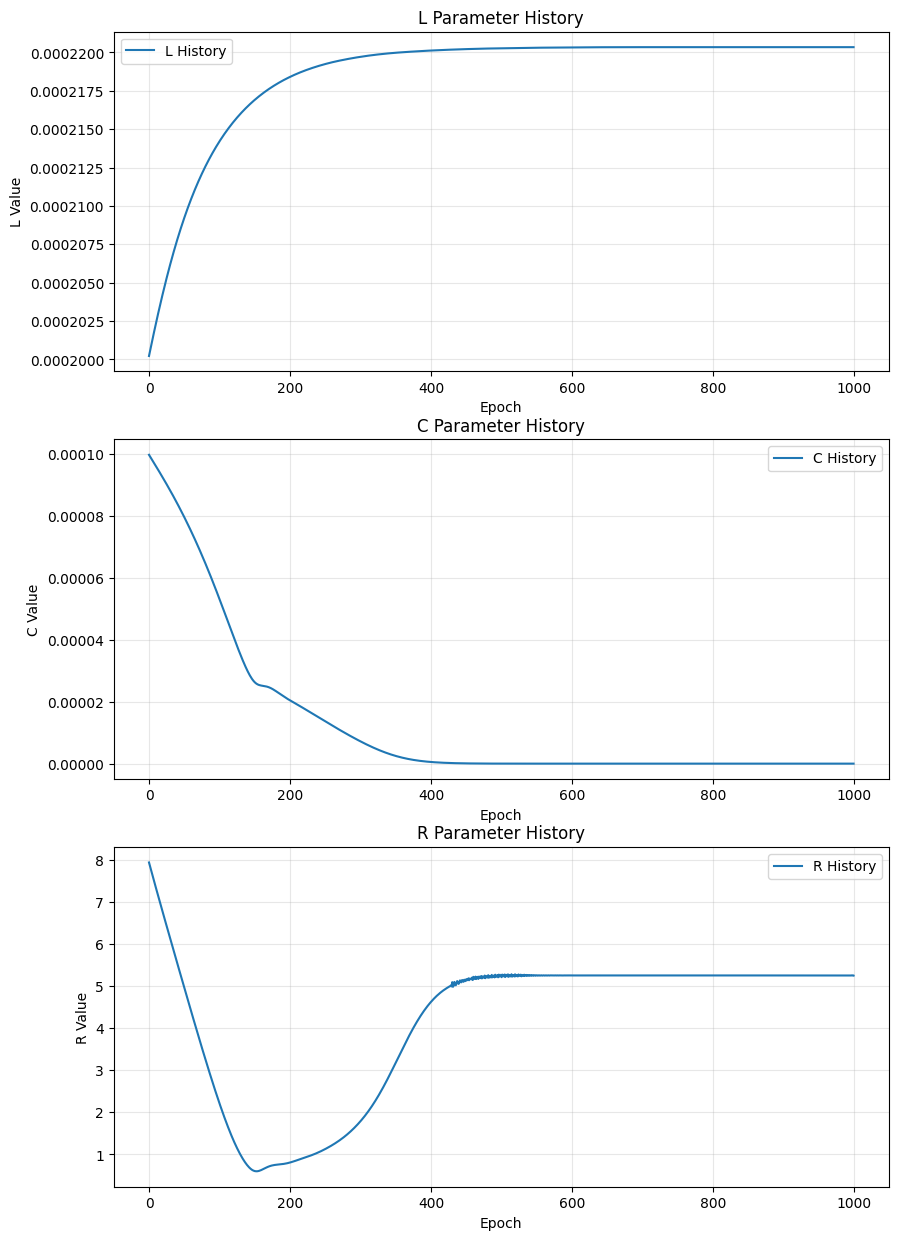

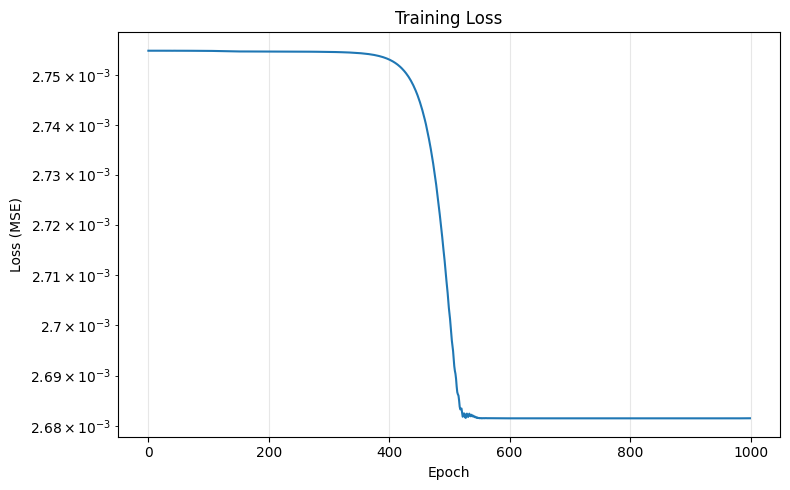

In [14]:
# 各パラメータの遷移
plt.figure(figsize=(10, 15))

# Plot L parameter
plt.subplot(3, 1, 1)
plt.plot(param_history["L"], label="L History")
plt.xlabel("Epoch")
plt.ylabel("L Value")
plt.title("L Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot C parameter
plt.subplot(3, 1, 2)
plt.plot(param_history["C"], label="C History")
plt.xlabel("Epoch")
plt.ylabel("C Value")
plt.title("C Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot R parameter
plt.subplot(3, 1, 3)
plt.plot(param_history["R"], label="R History")
plt.xlabel("Epoch")
plt.ylabel("R Value")
plt.title("R Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)


# 損失関数の履歴を別にプロット（わかりやすくするため）
plt.figure(figsize=(8, 5))
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True, alpha=0.3)
plt.title("Training Loss")

plt.tight_layout()
plt.show()

# シミュレーションして、実測値と比較する

t について、実測値と比較しない場合は適当な t でも構わないが、今回は実測値と比較したいため、すべての時刻 t において実測値が存在する必要があるので、実測値の t から値を抽出して t の軸とする

1. t_all の 0 以上の値だけを抽出
2. 0 から dt (1 周期を 200 プロット分の時間)刻みでサンプリングして、t_sim を作成
   1. t+dt の点がなければ t + dt 以上で最小の点とする


In [15]:
# t 作成(iL, vC の実測値の時刻を抽出も)
dt: float = T / 200
t_all_pos: np.ndarray = t_all[t_all >= 0]

t_sim: list[float] = []
iL_true: list[float] = []
vC_true: list[float] = []
t_now: float = 0.0
while t_now <= t_all_pos[-1]:
    # t_now以上で最小の実測時刻を取得
    idx: int = np.searchsorted(t_all_pos, t_now, side="left")
    if idx < len(t_all_pos):
        t_sim.append(float(t_all_pos[idx]))
        iL_true.append(float(iL_all[idx]))
        vC_true.append(float(vC_all[idx]))
    else:
        # 範囲外になった場合はbreak
        break
    t_now += dt
t_sim = np.array(t_sim)
iL_true = np.array(iL_true)
vC_true = np.array(vC_true)

# dt 作成
dt_sim: np.ndarray = np.diff(t_sim)

# u 作成
duty_phase = (t_sim[:-1] % T) / T
u_sim = (duty_phase < duty).astype(int)

# vs 作成
vs_sim = np.ones(len(t_sim) - 1) * Vin


print(len(t_sim))
print(len(dt_sim))
print(len(u_sim))
print(len(vs_sim))


35820
35819
35819
35819


In [16]:
va_sim = np.zeros(len(t_sim) - 1)
with torch.no_grad():
    h_sim = [torch.zeros(1, 2)]
    for i in range(len(t_sim) - 1):
        h_next, va_sim[i] = model(h_sim[-1], vs_sim[i], u_sim[i], dt_sim[i])
        h_sim.append(h_next)
    h_sim = torch.cat(h_sim, dim=0)

iL_sim = h_sim[:, 0].numpy()
vC_sim = h_sim[:, 1].numpy()


In [17]:
# 各配列にnull(欠損値)があるか調べる
arrays = {
    "t_sim": t_sim,
    "u_sim": u_sim,
    "va_sim": va_sim,
    "vs_sim": vs_sim,
    "iL_sim": iL_sim,
    "vC_sim": vC_sim,
}


nan_counts = {}
for name, arr in arrays.items():
    # NaN の個数をカウント
    count_nan: int = np.isnan(arr).sum()
    nan_counts[name] = count_nan
    print(f"{name} のNaNの個数: {count_nan}")


t_sim のNaNの個数: 0
u_sim のNaNの個数: 0
va_sim のNaNの個数: 0
vs_sim のNaNの個数: 0
iL_sim のNaNの個数: 35552
vC_sim のNaNの個数: 35552


# まとめ

- 実機データでは学習できなかった
  - 出力の iL, vC に NaN が多く含まれている
- (仮説)
  - おそらく、推論したときの C の値が小さすぎて(6.3e-9 ぐらい)、vC の更新の時に爆発的に大きくなって inf → nan になった
    - 先行研究の方だと clamper でそれを解決してる？
